----
# Why is pure advection so tricky?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We try to solve the **transient advection equation** for the variable $u$ in one spatial dimension $x$ [m]
and the time $t$ [s]:
$$
\frac{\partial u}{\partial t} + v \frac{\partial u}{\partial x} = 0
$$

- We need to define the velocity $v$ [m/s]
- We need an initial solution $u(t=0)=u_0$.

Define the **spatial discretisation**, $x_i \in [0,1], i \in [1,nx]$:

In [2]:
nx = 101
x  = np.linspace(0,1,nx)
dx = x[1]-x[0]
print(x,dx)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ] 0.01


Define the **initial condition**, a sine function:

Or, as alternative a Gaussian function:

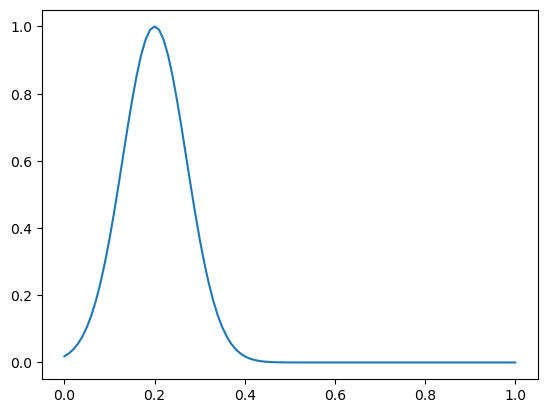

In [3]:
choice = 'sine'
choice = 'gauss'

if (choice == 'sine'):
    u0 = np.sin(2*np.pi*x)
elif (choice == 'gauss'):
    mu    = 0.2
    sigma = 0.1
    u0 = np.exp(-(x-mu)**2/(sigma)**2)
plt.plot(x,u0)

Define the **temporal discretisation**, $t_n \in [0,0.2], n \in [1,N]$:

In [15]:
N  = 11
t  = np.linspace(0,0.2,N)
dt = t[1]-t[0]
print(t,dt)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ] 0.02


Define **velocity** $v>0$ and calculate the **Corant number**:
$$
Co = \frac{v dt}{dx}
$$
The Courant number needs to be smaller than one for numerical stability, $Co<1$.

In [16]:
v  = 0.5
Co = v*dt/dx
print('Co: ',Co)

Co:  1.0


----
## FTCS scheme

Use a **forward time, centered space** discretisation scheme:

$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}
+ v \frac{u_{i+1}^{n}-u_{i-1}^{n}}{2\Delta x}
= 0
$$
Re-formulate to obtain the solution at the next time step:
$$
u_{i}^{n+1} = u_{i}^{n} - \frac{v \Delta t}{2 \Delta x} \left( u_{i+1}^{n}-u_{i-1}^{n} \right)
$$

Procedure:
- choose $v$, $nx$, $N$
- calculate $\Delta x$, $\Delta t$
- Check $Co<1$
- Define initial condition $u(t=0)=u_0$
- solve for new time steps

In [13]:
U = np.zeros(N*nx).reshape(nx,N)
u = np.zeros(nx)
print(U.shape)

U[:,0] = u0

for n in range(1,t.shape[0]):
    uold = U[:,n-1]
    for i in range(u.shape[0]):
        u[i] = uold[i] - v*dt/2/dx * (np.roll(uold,-1)[i] - np.roll(uold,+1)[i])
    U[:,n] = u
    
# Note np.roll(u,-1) is u_{i+1}
# Note np.roll(u,+1) is u_{i-1}

(101, 11)


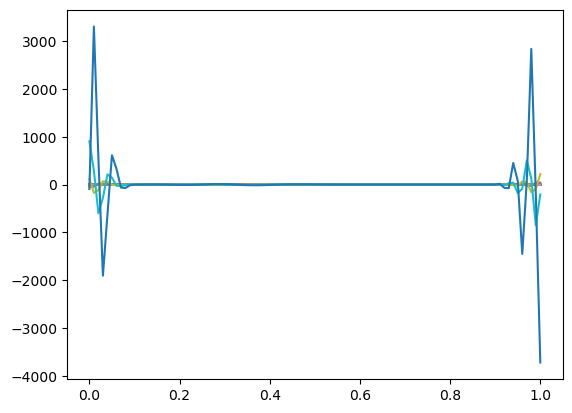

In [14]:
for n in range(N):
    plt.plot(x,U[:,n])

**Why did it fail?**

<img style="height:5cm;" src="images/PDE_FTCS.jpg">

The FTCS scheme uses a point ($u_{i+1}^n$), which is located ahead of the advection direction ($v>0$),
thus tries to use an information, which is not given.

----
## Upwind scheme

Use an **upwind** discretisation scheme:

$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}
+ v \frac{u_{i}^{n}-u_{i-1}^{n}}{\Delta x}
= 0
$$
Re-formulate to obtain the solution at the next time step:
$$
u_{i}^{n+1} = u_{i}^{n} - \frac{v \Delta t}{\Delta x} \left( u_{i}^{n}-u_{i-1}^{n} \right)
$$

In [9]:
U = np.zeros(N*nx).reshape(nx,N)
u = np.zeros(nx)
print(U.shape)

U[:,0] = u0

for n in range(1,t.shape[0]):
    uold = U[:,n-1]
    for i in range(u.shape[0]):
        u[i] = uold[i] - v*dt/dx * (np.roll(uold,0)[i] - np.roll(uold,+1)[i])
    U[:,n] = u

(101, 11)


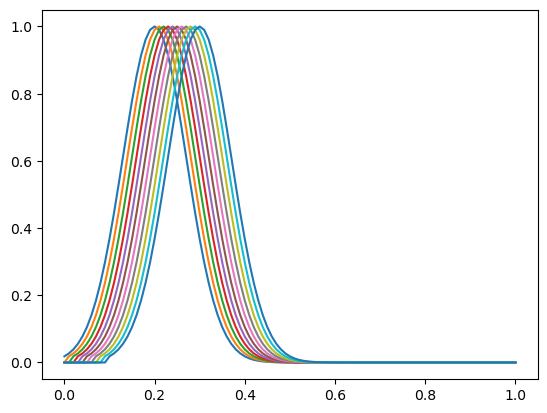

In [10]:
for n in range(N):
    plt.plot(x,U[:,n])

The result is **much more stable**. 

<img style="height:5cm;" src="images/PDE_upwind.jpg">

We examine why by re-writing the advection term:
- add a new (diffusion) term
- substract the same term
- rearrange terms

$$
\begin{array}{rcl}
v \frac{u_{i}^{n}-u_{i-1}^{n}}{\Delta x}
&=&
v \frac{u_{i+1}^{n}-u_{i-1}^{n}}{2\Delta x}
-v \frac{u_{i+1}^{n}-u_{i-1}^{n}}{2\Delta x}
+v \frac{u_{i}^{n}-u_{i-1}^{n}}{\Delta x} \\
&=&
v \frac{u_{i+1}^{n}-u_{i-1}^{n}}{2\Delta x}
+ v \frac{2u_i - 2u_{i-1} - u_{i+1} + u_{i-1}}{2 \Delta x} \\
&=&
v \underbrace{\frac{u_{i+1}^{n}-u_{i-1}^{n}}{2\Delta x}}_{\mbox{FTCS}}
- \frac{v \Delta x}{2} \underbrace{\frac{u_{i+1} - 2u_{i} + u_{i-1}}{\Delta x^2}}_{\mbox{numerical diffusion}}
\end{array}
$$

The **upwind scheme** is a **forward time centered space scheme**, but with **numerical diffusion**,
which stabilises the solution!

This means, with the **upwind scheme** we numerically solve an **advection-diffusion problem**,
were the numerical diffusion scales with advection velocity and spatial discretisation:
$$
\frac{\partial u}{\partial t} + v \frac{\partial u}{\partial x} 
= \underbrace{\frac{v \Delta x}{2}}_{D} \frac{\partial^2 u}{\partial x^2}
$$

... done